# ADS Project 2022 Gruppe 7:  Image Classification with Transfer learning

## Setup

In [ ]:
#ONLY RELEVANT FOR AWS SAGEMAKER: installing mechanicalsoup
!pip install mechanicalsoup

In [ ]:
##ONLY RELEVANT FOR AWS SAGEMAKER: installing wget
!pip install wget

In [ ]:
##ONLY RELEVANT FOR AWS SAGEMAKER: installing tensorflow
!pip install tensorflow

In [2]:
#stuff for web scraping
import mechanicalsoup
import wget

#stuff to handle files and folders
import os
import glob
import shutil

#other stuff
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import time

## Data

In [ ]:
#NUR RELEVANT FÜR AWS SAGEMAKER: Move kaggle secret to the right location
#mv /home/ec2-user/SageMaker/kaggle.json /home/ec2-user/.kaggle

In [2]:
#connect to kaggle api
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [3]:
#download dataset from kaggle using api
api.dataset_download_files('shaunthesheep/microsoft-catsvsdogs-dataset', path='./')

In [4]:
#unzip the zip file
import zipfile
with zipfile.ZipFile('microsoft-catsvsdogs-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('catsvsdogs')

In [5]:
#resize a subset of images of dogs
dst_dir = 'catsvsdogs/resized/dogs'
os.makedirs(dst_dir, exist_ok=True)

files = glob.glob('./catsvsdogs/PetImages/Dog/*.jpg')

i = 0

for f in files: 
    i = i + 1
    try:
        img = Image.open(f)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img_resize = img.resize((192, 192))
        root, ext = os.path.splitext(f)
        basename = os.path.basename(root)
        img_resize.save(os.path.join(dst_dir, basename + ext))
    except (IOError) as e: #in some instances there were some corrupted files in the zip file.
        print ('Bad file:', f)
        pass
    if i == 3000:
        break

/Users/lukaszimmermann/opt/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [6]:
#Resize a subset of images of cats 
dst_dir = 'catsvsdogs/resized/cats'
os.makedirs(dst_dir, exist_ok=True)

files = glob.glob('./catsvsdogs/PetImages/Cat/*.jpg')

i = 0

for f in files:
    i = i + 1
    try:
        img = Image.open(f)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img_resize = img.resize((192, 192))
        root, ext = os.path.splitext(f)
        basename = os.path.basename(root)
        img_resize.save(os.path.join(dst_dir, basename + ext))
    except (IOError) as e: #in some instances there were some corrupted files in the zip file.
        print ('Bad file:', f)
        pass
    if i == 3000:
        break

In [7]:
#making sure the folders were created correctly
data_dir = os.path.join(os.curdir, 'catsvsdogs/resized')
os.listdir(data_dir)

['dogs', 'cats']

In [8]:
#OPTIONAL: Delete original unziped of data

shutil.rmtree(os.path.join(os.curdir, 'catsvsdogs/PetImages'))

## Image Classification 

In [9]:
BATCH_SIZE = 32
IMG_SIZE = (192, 192)

#shuffle immer mit seed, sonst kann man nicht das gleiche Dataset in Valdiation & Train verwenden.

train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "training")

validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "validation")

Found 6000 files belonging to 2 classes.
Using 4800 files for training.
Found 6000 files belonging to 2 classes.
Using 1200 files for validation.


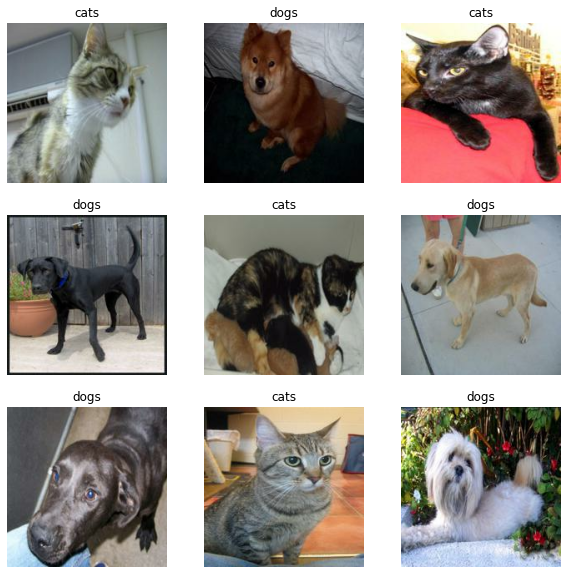

In [10]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Creation of test set by splitting the validation set into batches and keep 1 for the test.

In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 10)
val_dataset = validation_dataset.skip(val_batches // 10)

#OPEN QUESTION

#Das Abändern der grünen Zahl beeinflusst die Accuracy stark. Warum?
#Was geschieht hier wirklich?


In [12]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 38
Number of test batches: 3


It is convenient to use buffered prefetching to load images from disk without having I/O become blocking. That is what the next cell does.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#OPEN QUESTION

#Was geschieht hier?

### Use data augmentation

In [14]:
#To reduce overfitting, pictures are flipped and rotated

with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip('horizontal'),
      tf.keras.layers.RandomRotation(0.2),
    ])

Let's repeatedly apply these layers to the same image and see the result.

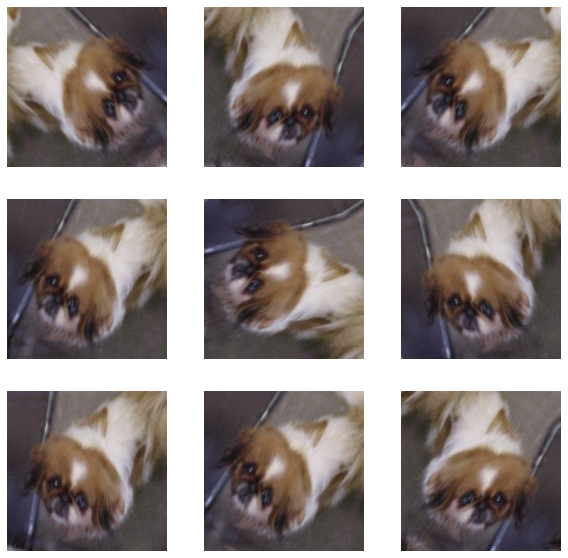

In [15]:
#test effect of augmentation

with tf.device('/cpu:0'):
    for image, _ in train_dataset.take(1):
      plt.figure(figsize=(10, 10))
      first_image = image[0]
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Choose Transfer Learning Model 

As a first execution of the notebook, we will use the following pre-trained model: **MobileNetV2** developed by Google (dowloaded via  `tf.keras.applications.MobileNetV2` ). This will be your base model. The big advantage is that it was trained on ImageNet data! So 1.4M images :) with a wide variety of categories like `jackfruit` and `syringe`. Not on smiles though...Will this help us in recognizing smiles??

Note: Every model was trained using specific image preprocessing requirements. YOU NEED TO CHECK EACH TIME WHAT PECULIAR OF A SPECIFIC MODEL!
Here the guide for MobileNetV2 https://keras.io/api/applications/mobilenet/.

This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. 
At best, you always use the preprocessing method included with the model.

In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [17]:
#rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

#OPEN QUESTION

#Wäre das noch nötig?

We saw in the lesson that, wen doing trasnfer learning, we don't use all the architecture but only the feature extraction.
The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [18]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `192x192x3` image into a `6x6x1280` block of features. Let's see what it does to an example batch of images:

In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


### a. Freeze weights, use the feature extraction as it is, attach a new classification head
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [20]:
#freeze convolutional base before compiling and training the model.
base_model.trainable = False

Let's take a look at the base model architecture

In [21]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 96, 96, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 96, 96, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 96, 96, 32)   0           ['bn_Conv1[0][

Let's now combine this model with a classification head, meaning some fully connected layers (tf.keras.layers.Dense). 

Build a model by chaining together the data augmentation, preproccesing, `base_model` and classification layers (note that the syntax is slighly different, we are using the [Keras Functional API]).



Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [22]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) #We need to set `training=False` as our model contains a `BatchNormalization` layer. More explanation here https://www.tensorflow.org/guide/keras/transfer_learning
x = tf.keras.layers.GlobalAveragePooling2D()(x) #this layer has the same purpose as tf.keras.layers.Flatten(). Need to connect something 2D to something 1D. Ask if you want to know more :)
#x = tf.keras.layers.Dense(10, activation="relu")(x)
#x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(5, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) 
model = tf.keras.Model(inputs, outputs)

#OPEN QUESTION

#Given the great performance, are more layers necessary? Didn't try what effect it would have yet...


Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 192, 192, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 192, 192, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                             

Above you see how many parameters you are actually training, and how many are frozen.

### Train the model



In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

38/38 [==============================] - 19s 470ms/step - loss: 0.8024 - accuracy: 0.4583


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.46


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
150/150 [==============================] - 92s 596ms/step - loss: 0.5771 - accuracy: 0.7023 - val_loss: 0.3487 - val_accuracy: 0.9033
Epoch 2/10
150/150 [==============================] - 89s 593ms/step - loss: 0.3522 - accuracy: 0.8637 - val_loss: 0.2158 - val_accuracy: 0.9450
Epoch 3/10
150/150 [==============================] - 86s 576ms/step - loss: 0.2603 - accuracy: 0.9052 - val_loss: 0.1621 - val_accuracy: 0.9575
Epoch 4/10
150/150 [==============================] - 84s 561ms/step - loss: 0.2170 - accuracy: 0.9227 - val_loss: 0.1345 - val_accuracy: 0.9642
Epoch 5/10
150/150 [==============================] - 83s 555ms/step - loss: 0.1903 - accuracy: 0.9323 - val_loss: 0.1175 - val_accuracy: 0.9650
Epoch 6/10
150/150 [==============================] - 83s 553ms/step - loss: 0.1729 - accuracy: 0.9398 - val_loss: 0.1065 - val_accuracy: 0.9683
Epoch 7/10
150/150 [==============================] - 81s 540ms/step - loss: 0.1699 - accuracy: 0.9373 - val_loss: 0.0982 - val_ac


Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

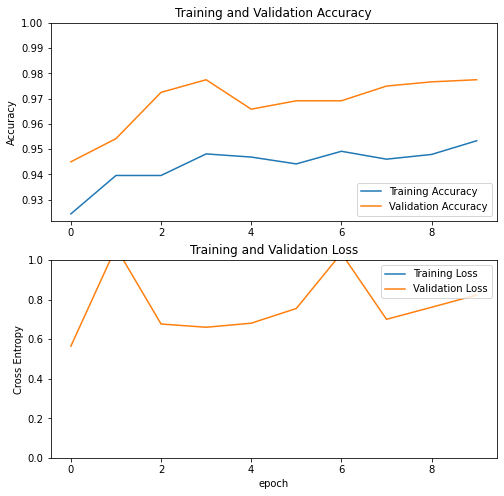

In [30]:
#plot learning curves of training and validation accuracy / loss.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

### b) Fine tuning - Überhaupt notwendig bei so hoher Accuracy?
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
#base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
#print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
#fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model.layers[:fine_tune_at]:
#  layer.trainable = False

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
#model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
#              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
#              metrics=['accuracy'])

In [ ]:
#model.summary()

Let's keep training from where we stopped before, so we can keep improving hopefully. 

In [ ]:
#fine_tune_epochs = 10
#total_epochs =  initial_epochs + fine_tune_epochs

#history_fine = model.fit(train_dataset,
#                         epochs=total_epochs,
#                         initial_epoch=history.epoch[-1],
#                         validation_data=validation_dataset)

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. Pay attention to not overfit!


In [ ]:
#acc += history_fine.history['accuracy']
#val_acc += history_fine.history['val_accuracy']

#loss += history_fine.history['loss']
#val_loss += history_fine.history['val_loss']

In [ ]:
#plt.figure(figsize=(8, 8))
#plt.subplot(2, 1, 1)
#plt.plot(acc, label='Training Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0, 1])
#plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
#plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

#plt.subplot(2, 1, 2)
#plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
#plt.plot([initial_epochs-1,initial_epochs-1],
#         plt.ylim(), label='Start Fine Tuning')
#plt.legend(loc='upper right')
#plt.title('Training and Validation Loss')
#plt.xlabel('epoch')
#plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [28]:
#Verify model performance on test set.

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 1s 375ms/step - loss: 0.0561 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Test with pictures obtained through web scraping

In [32]:
#create browser object and pass google images url to it.
browser = mechanicalsoup.StatefulBrowser()
url = 'https://www.google.ch/imghp?hl=en&ogbl'
    
browser.open(url)
print(browser.get_url())

https://www.google.ch/imghp?hl=en&ogbl


In [33]:
#Find pictures of cats...

browser.get_current_page()

browser.select_form()
#browser.get_current_form().print_summary()

search_term = 'Katze'
browser['q'] = search_term

browser.launch_browser()
response = browser.submit_selected()

new_url = browser.get_url()
browser.open(new_url)

page = browser.get_current_page()
all_images = page.find_all('img')

#... and save them into a list.

image_source_cats = []
for image in all_images:
    image = image.get('src')
    image_source_cats.append(image)
    
image_source_cats = [image for image in image_source_cats if image.startswith('https')]

In [34]:
#Find pictures of dogs...

browser.get_current_page()

browser.select_form()
#browser.get_current_form().print_summary()

search_term = 'Hund'
browser['q'] = search_term

browser.launch_browser()
response = browser.submit_selected()

new_url = browser.get_url()
browser.open(new_url)

page = browser.get_current_page()
all_images = page.find_all('img')

#... and save them into a list.

image_source_dogs = []
for image in all_images:
    image = image.get('src')
    image_source_dogs.append(image)
    
image_source_dogs = [image for image in image_source_dogs if image.startswith('https')]

In [35]:
path = os.getcwd()
dst_dir_wbscrpng = os.path.join(path + '/catsordogs')
os.makedirs(dst_dir_wbscrpng, exist_ok=True)

#save cats

c = 0

for image in image_source_cats:
    save_as = os.path.join(dst_dir_wbscrpng, 'catordog' + str(c) + '.jpg')
    wget.download(image, save_as)
    c += 1

#save dogs   

d = c

for image in image_source_dogs:
    save_as = os.path.join(dst_dir_wbscrpng, 'catordog' + str(d) + '.jpg')
    wget.download(image, save_as)
    d += 1

This image most likely belongs to cats.


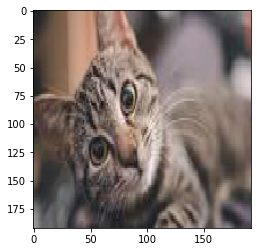

This image most likely belongs to dogs.


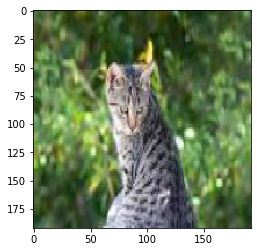

This image most likely belongs to cats.


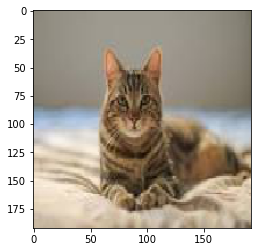

This image most likely belongs to dogs.


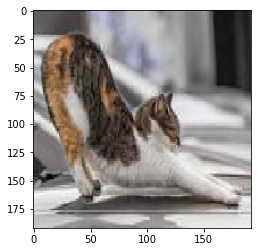

This image most likely belongs to dogs.


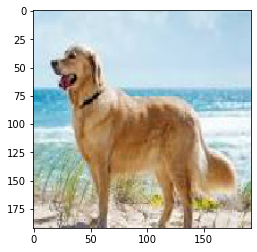

This image most likely belongs to dogs.


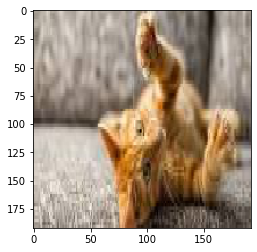

This image most likely belongs to dogs.


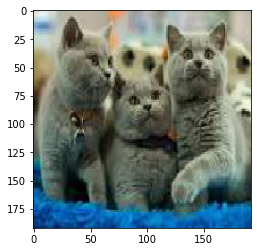

This image most likely belongs to cats.


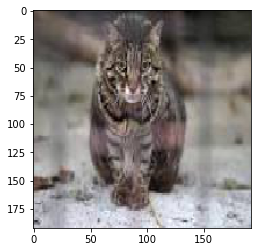

This image most likely belongs to cats.


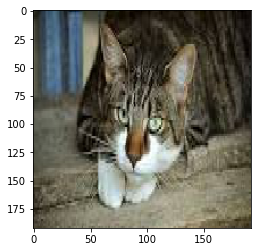

This image most likely belongs to dogs.


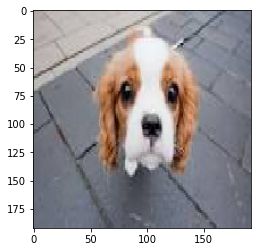

This image most likely belongs to cats.


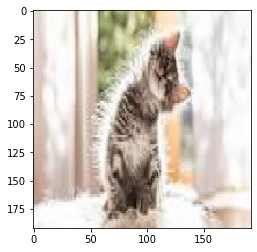

This image most likely belongs to dogs.


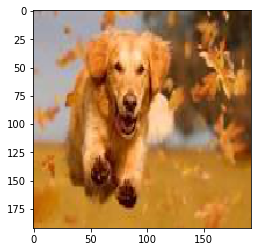

This image most likely belongs to cats.


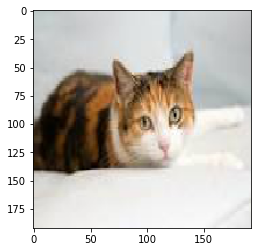

This image most likely belongs to cats.


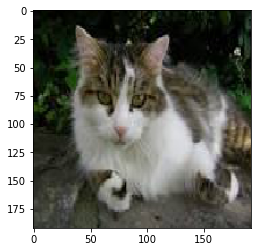

This image most likely belongs to dogs.


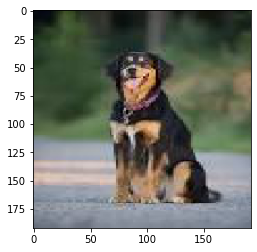

This image most likely belongs to cats.


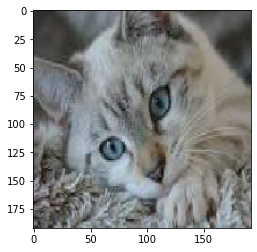

This image most likely belongs to cats.


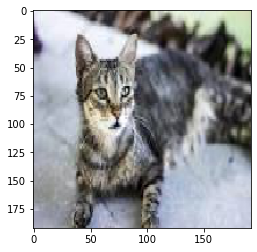

This image most likely belongs to cats.


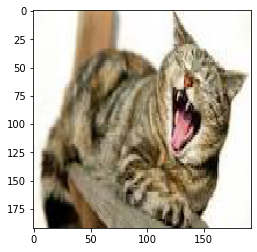

This image most likely belongs to dogs.


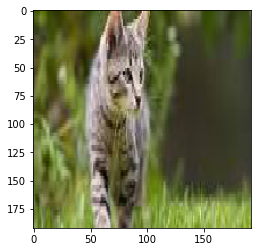

This image most likely belongs to cats.


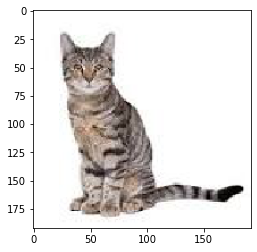

This image most likely belongs to dogs.


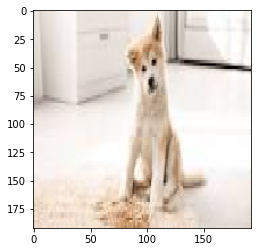

This image most likely belongs to dogs.


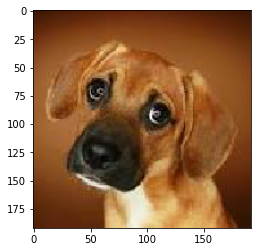

This image most likely belongs to dogs.


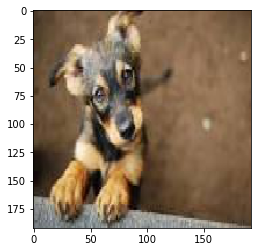

This image most likely belongs to dogs.


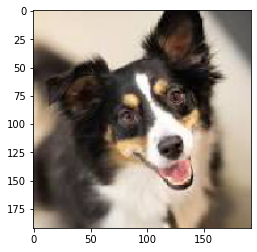

This image most likely belongs to dogs.


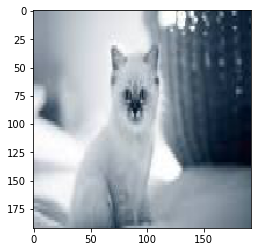

This image most likely belongs to dogs.


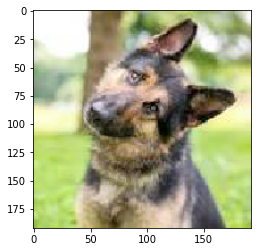

This image most likely belongs to dogs.


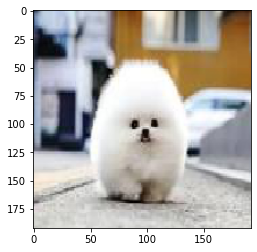

This image most likely belongs to dogs.


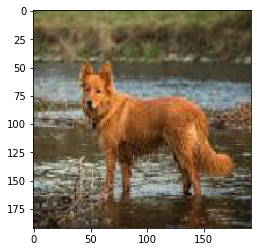

This image most likely belongs to dogs.


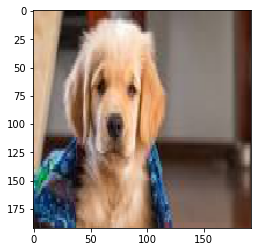

This image most likely belongs to cats.


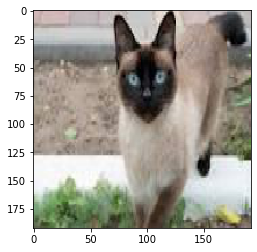

This image most likely belongs to dogs.


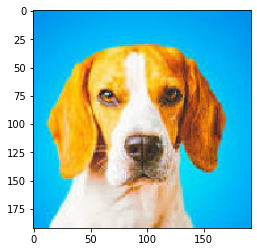

This image most likely belongs to dogs.


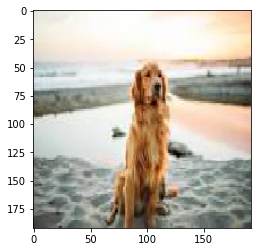

This image most likely belongs to cats.


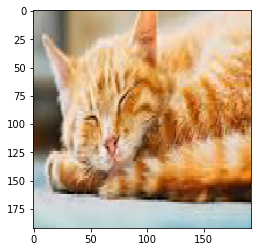

This image most likely belongs to dogs.


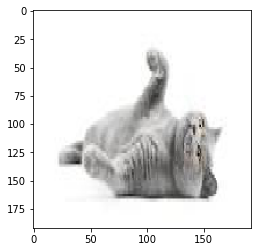

This image most likely belongs to dogs.


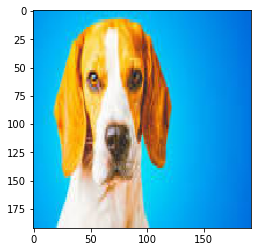

This image most likely belongs to dogs.


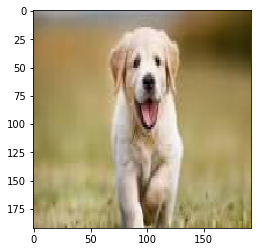

This image most likely belongs to dogs.


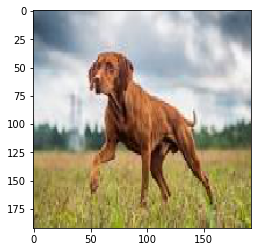

This image most likely belongs to dogs.


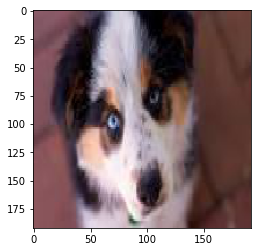

This image most likely belongs to dogs.


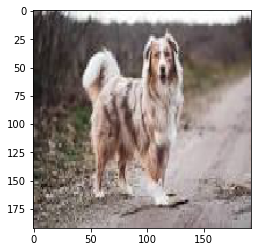

This image most likely belongs to dogs.


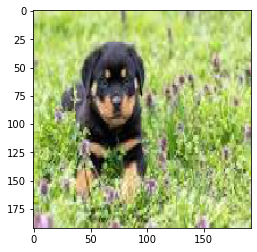

In [36]:
#Make and print predictions

images_to_predict = os.listdir('./catsordogs')

for i in images_to_predict: 
    img = tf.keras.utils.load_img(dst_dir_wbscrpng + "/" +i, target_size=(192,192))

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Add the image to a batch where it's the only member.

    prediction = model.predict_on_batch(img_array).flatten() #Predict on batch fügt eine Dimension hinzu, welche durch flatten wieder gelöscht werden soll.

    prediction = tf.where(prediction < 0.5, 0, 1) #das ist die threshold. 50% = 0, 50% = 1.
    
    print(
        "This image most likely belongs to {}:"
        .format(class_names[prediction[0]])
        )
    #making sure every image is printed with it's prediction.
    plt.imshow(img)
    plt.show()
    time.sleep(0.01)
